순서가 중요한 데이터를 다룰 때에는 RNN 을 주로 활용함

RNN은 순서를 특징으로 받아드리는 구조가 있음

RNN의 layer는 자기 자신한테도 돌아감(순환신경망)

순환신경망 때문에 앞의 계산 값이 뒤의 계산에도 영향을 미침

RNN은 데이터 하나 당 최종 출력이 하나 나오는게 아니고 타임스탭(특정 단위)가 전부 들어가야 출력이 하나 나옴

기울기 소실 문제를 해결하기 위해 LSTM을 사용하기도 함

LSTM을 번역에 활용할 때 집중할 단어를 정해주는 것을 어텐션이라고 함

트랜스포머는 한 배치 자체를 모델에 순서와 함께 넣음

요즘 RNN은 언어 처리에 잘 안쓰이고 로그, 주식, 비트코인, 농산물 가격 등에 사용함

#순환신경망 주식 예측 (테슬라 주식데이터)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf

#1.데이터 준비

In [ ]:
# !pip install yfinance

In [4]:
import yfinance as yf

tsla = yf.Ticker('TSLA')
df = tsla.history(period='max')
df.shape

(3653, 7)

In [6]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


#3.데이터 정보

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2010-06-29 00:00:00-04:00 to 2025-01-02 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3653 non-null   float64
 1   High          3653 non-null   float64
 2   Low           3653 non-null   float64
 3   Close         3653 non-null   float64
 4   Volume        3653 non-null   int64  
 5   Dividends     3653 non-null   float64
 6   Stock Splits  3653 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 228.3 KB


In [8]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


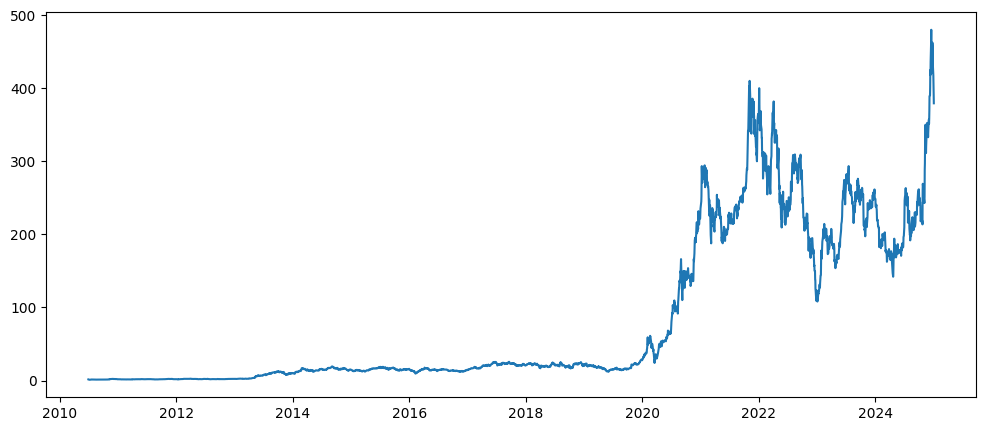

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.show()

In [10]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


#3.피처 추가

In [13]:
# 3일 평균

# 3개씩 연속으로 묶어서 평균내는거
df['ma3'] = np.around(df['Close'].rolling(window=3).mean(), 0)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma3
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,NaN
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,NaN
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,2.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,1.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,1.0


In [14]:
df['ma5'] = np.around(df['Close'].rolling(window=5).mean(), 0)
df['ma20'] = np.around(df['Close'].rolling(window=20).mean(), 0)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma3,ma5,ma20
Date,,,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,NaN,NaN,NaN
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,NaN,NaN,NaN
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,2.0,NaN,NaN
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,1.0,NaN,NaN
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,1.0,1.0,NaN


In [15]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0
ma3,2
ma5,4
ma20,19


In [16]:
# 결측치 삭제

df=df.dropna()

In [18]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0
ma3,0
ma5,0
ma20,0


#4.데이터 분리

In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'ma3', 'ma5', 'ma20'],
      dtype='object')

In [21]:
X = df.drop(['Close', 'Volume', 'Dividends', 'Stock Splits'], axis = 1)
y = df['Close']
X.head()

,Open,High,Low,ma3,ma5,ma20
Date,,,,,,
2010-07-27 00:00:00-04:00,1.394000,1.412000,1.350667,1.0,1.0,1.0
2010-07-28 00:00:00-04:00,1.370000,1.393333,1.367333,1.0,1.0,1.0
2010-07-29 00:00:00-04:00,1.384667,1.392000,1.333333,1.0,1.0,1.0
2010-07-30 00:00:00-04:00,1.346667,1.362667,1.303333,1.0,1.0,1.0
2010-08-02 00:00:00-04:00,1.366667,1.398000,1.355333,1.0,1.0,1.0


In [29]:
def make_sequence_dataset(X,y,window_size=20):
  feature_list = []
  label_list = []

  for i in range(len(X)-window_size):
    ux = X[i:i+window_size]
    uy = y[i+window_size]
    feature_list.append(ux)
    label_list.append(uy)

  return np.array(feature_list), np.array(label_list)

In [30]:
# RNN에 집어넣으려면 데이터가 이런 형태가 되어야 함
# 한번 들어갈 때 6개씩 타임스탭이 20개 있어야 함
X_w, y_w = make_sequence_dataset(X, y, 20)
X_w.shape, y_w.shape

<ipython-input-29-fdb320b28268>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uy = y[i+window_size]


((3614, 20, 6), (3614,))

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_w, y_w,
                 test_size=0.2,
                 shuffle=False,
                 random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2891, 20, 6), (723, 20, 6), (2891,), (723,))

### RNN할 때 스케일링이 필수인가 아닌가?

##5.모델 만들기

In [45]:
from keras import layers

# 좀 다른 방식
model = keras.Sequential()
model.add(layers.Input(shape=(20,6)))
# RNN에 LSTM 이라는 레이어가 있음
model.add(layers.LSTM(units=50, activation='relu'))
# model.add(layers.LSTM(units=50, activation='relu'))
model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse']
)

In [57]:
epochs=100
batch_size=16

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2536 - mse: 0.2536 - val_loss: 1600.0399 - val_mse: 1600.0399
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2808 - mse: 0.2808 - val_loss: 784.3337 - val_mse: 784.3337
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2197 - mse: 0.2197 - val_loss: 982.9020 - val_mse: 982.9020
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3017 - mse: 0.3017 - val_loss: 2003.8486 - val_mse: 2003.8486
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 218.6783 - mse: 218.6783 - val_loss: 4052.4314 - val_mse: 4052.4314
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.9525 - mse: 7.9525 - val_loss: 14835.0410 - val_mse: 14835.0410
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 10.9516 - mse: 10.9516 - val_loss: 5976.9146 - val_mse: 5976.9146
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7399 - mse: 1.7399 - val_loss: 7920.7529 - val_mse

In [58]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'], label='train_loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
  plt.title('Loss Curve')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('epoch')
  plt.ylabel('mse')
  plt.plot(hist['epoch'], hist['mse'], label='train_mse')
  plt.plot(hist['epoch'], hist['val_mse'], label='val_mse')
  plt.title('mse Curve')
  plt.legend()

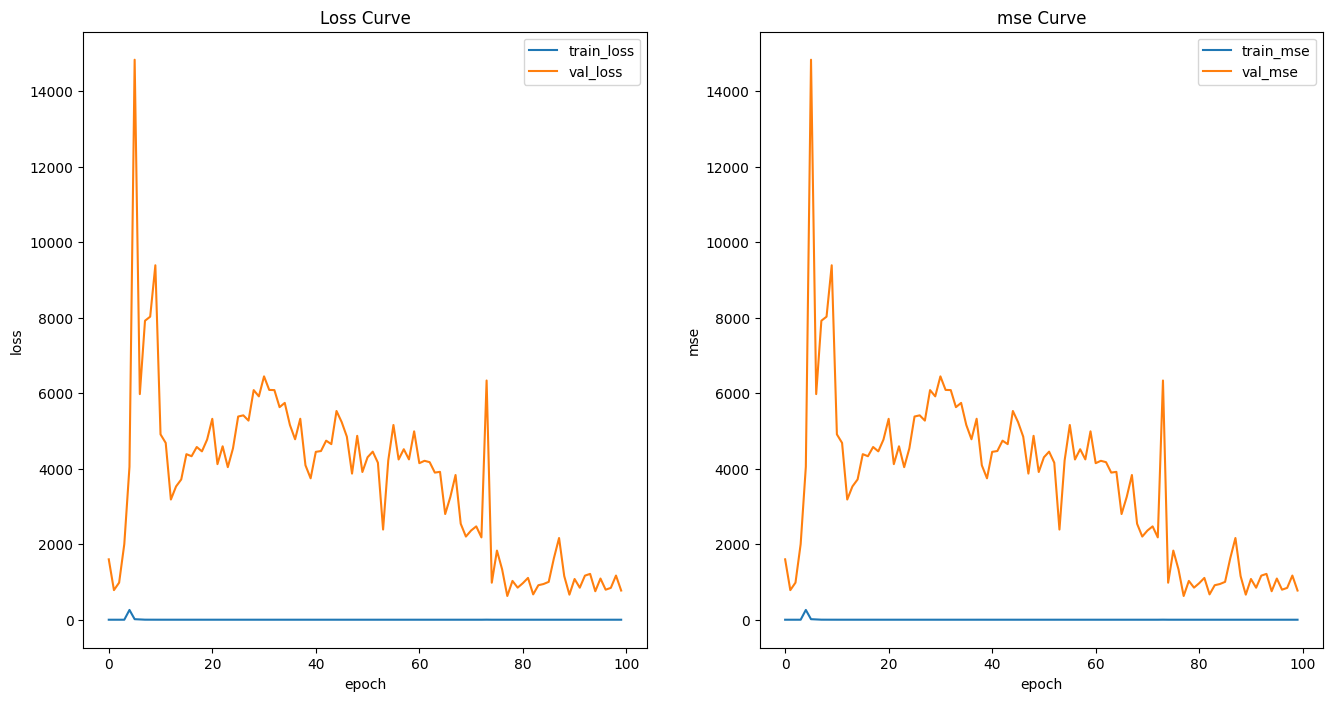

In [59]:
plot_history(history)

##6.테스트

In [60]:
y_pred = model.predict(X_test)
y_pred[:10]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


array([[317.9539 ],
       [258.242  ],
       [248.718  ],
       [276.99557],
       [234.8591 ],
       [231.38237],
       [193.52899],
       [291.33386],
       [297.27252],
       [312.71478]], dtype=float32)

In [61]:
y_test[:10]

array([307.79666138, 292.1166687 , 285.66000366, 273.84332275,
       254.67999268, 266.92333984, 269.95666504, 290.14334106,
       288.12332153, 293.29666138])

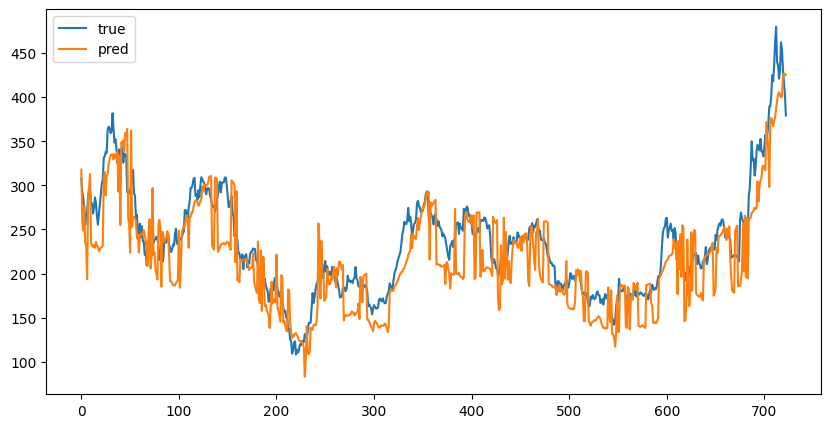

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()